# CIFAR-10 Classification with Transfer Learning (ResNet18)

## Overview
This project is image classification pipeline using transfer learning on the CIFAR-10 dataset with PyTorch and a pretrained ResNet18 model. It includes staged fine-tuning, checkpointing, learning rate scheduling, and evaluation via confusion matrix and loss/accuracy plots.

## Dataset info

We use the CIFAR-10 dataset from torchvision.datasets. It has 50,000 training images and 10,000 test images. Image size is 32x32. There are 10 classes: *airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.*  


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader
from torchvision import models

## Data Augmentation
Transforms on training dataset:
- Resize to 224x224 (for better performance with ResNet18)

- Random horizontal flip

- Random crop with padding

- Color jitter (brightness, contrast, saturation, hue)

- Normalize to [ -1, 1 ]

- Random erasing (to simulate occlusions and improve generalization)

Transforms on test dataset:
- Resize to 224x224

- Normalize to [ -1, 1 ]



In [ ]:
def get_dataloaders(batch_size=128):
    transform_train = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(224, padding=4),
        transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,) * 3, (0.5,) * 3),
        transforms.RandomErasing(p=0.25)
    ])
    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5,) * 3, (0.5,) * 3)
    ])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    return trainloader, testloader

## Custom Classifier get_model()

Initialize a pretrained ResNet18 model and modify the final fc layer to make it suitable for CIFAR-10. Freeze

### **Steps:**

1. **Load the Pretrained ResNet18 Model**  from the `torchvision.models` library. `weights=models.ResNet18_Weights.DEFAULT` ensures we use the ResNet18 model pretrained on ImageNet, providing feature extractor.

2. **Freeze All Layers**, which means their weights won't be updated during the initial training.

3. **Modify the Final Layer (Fully Connected Layer)**:  
 The new classifier consists of:
   - A **Dropout** layer with a rate of 0.5 to prevent overfitting by randomly dropping half of the neurons during training.
   - A **Linear** layer that maps the output features of the previous layer to the `num_classes`, 10.

4. **Unfreeze the Classifier Layer**: Unfreeze the weights of the new fully connected layer, allowing them to be updated during training.

This function returns the modified model ready for fine-tuning on the CIFAR-10 dataset.


In [ ]:
def get_model(num_classes=10):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    for param in model.parameters():
        param.requires_grad = False
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model.fc.in_features, num_classes)
    )
    for param in model.fc.parameters():
        param.requires_grad = True
    return model

## Function unfreeze_layers()
This function is used to unfreeze specific layers of the model so that their parameters will be updated during training

In [ ]:
def unfreeze_layers(model, layers_to_unfreeze):
    for name, param in model.named_parameters():
        if any(layer in name for layer in layers_to_unfreeze):
            param.requires_grad = True

## function save_checkpoint()
This function saves the current state of the model during training to a file so that you can resume training or evaluate the model later. It creates a checkpoint file that contains the model weights, optimizer state, epoch number, accuracy, and stage, which can be loaded back later using the load_latest_checkpoint function.

In [ ]:
def save_checkpoint(model, optimizer, epoch, accuracy, stage):
    state = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'accuracy': accuracy,
        'stage': stage
    }
    filename = f'checkpoint_stage{stage}_epoch{epoch}.pth'
    torch.save(state, filename)
    print(f">>> Checkpoint saved: {filename}")

## Function load_latest_checkpoint()
This function loads the most recent checkpoint from disk to resume training. It returns the model and optimizer state (if provided), epoch, accuracy, and stage.

- Flexibility: The function allows to resume training from the most recent checkpoint.

- Model and Optimizer States: Both the model weights and optimizer states can be loaded, which ensures that the training process will continue without any problem.

- Error Handling: The function is designed to handle cases where no checkpoints are found or if the optimizer state is missing.

In [ ]:
def load_latest_checkpoint(model, optimizer=None):
    import re

    resume_epoch = 0
    best_acc = 0
    resume_stage = 0

    # Check if checkpoint exists in the current directory
    checkpoint_files = [f for f in os.listdir('.') if f.startswith('checkpoint_stage') and f.endswith('.pth')]

    if not checkpoint_files:
        print("No checkpoints found. Starting from scratch.")
        return model, optimizer, resume_epoch, best_acc, resume_stage

    # Parse stage and epoch numbers from filenames
    checkpoint_info = []
    for filename in checkpoint_files:
        match = re.match(r'checkpoint_stage(\d+)_epoch(\d+)\.pth', filename)
        if match:
            stage = int(match.group(1))
            epoch = int(match.group(2))
            checkpoint_info.append((filename, stage, epoch))

    if not checkpoint_info:
        print("No valid checkpoints found. Starting from scratch.")
        return model, optimizer, resume_epoch, best_acc, resume_stage

    # Sort by stage first (descending), then by epoch (descending)
    checkpoint_info.sort(key=lambda x: (x[1], x[2]), reverse=True)
    latest_checkpoint, latest_stage, latest_epoch = checkpoint_info[0]

    print(f"Found latest checkpoint: {latest_checkpoint} (Stage {latest_stage}, Epoch {latest_epoch})")

    try:
        checkpoint = torch.load(latest_checkpoint)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Successfully loaded model weights from checkpoint")

        # Only load optimizer state if optimizer is provided
        if optimizer is not None:
            try:
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                print(f"Successfully loaded optimizer state from checkpoint")
            except (ValueError, KeyError) as e:
                print(f"Warning: Could not load optimizer state: {e}")
                print("Training will continue with a fresh optimizer.")

        resume_epoch = checkpoint.get('epoch', latest_epoch)
        best_acc = checkpoint.get('accuracy', 0)
        resume_stage = checkpoint.get('stage', latest_stage)

        print(f"Resuming from Stage {resume_stage}, Epoch {resume_epoch} with accuracy {best_acc:.2f}%")
        return model, optimizer, resume_epoch, best_acc, resume_stage

    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        print("Starting from scratch.")
        return model, optimizer, 0, 0, 0

## Function train_model()

 is designed to train a neural network model with multiple stages of unfreezing layers, tracking training progress, saving checkpoints, and evaluating the model's performance.

### Locigal flow of the function

1.   Device setup (CPU or GPU)
2.   Loss funtion (cross-entropy with label smoothing)
3.   Lists to store train,test losses, accruacies and checkpoint for each epoch
4. Load the latest checkpoint
5. Iterate over stages
    - skip already completed stages
6. Unfreeze layers and optimizer
7. loop through epochs
    - train
    - validation
    - print the progress
    - save the best model
8. Save checkpoint logs as a csv file
9. Return train losses, test losses, accuracies



Also after each checkpoint for every class provides metrics, such as
1. Precision: it is the ratio of correctly predicted positive observations to the total predicted positives. In other words, out of all the instances the model predicted as positive, how many were actually positive?
2. Recall (Sensitivity or True Positive Rate): it is the ratio of correctly predicted positive observations to all observations in the actual positive class. In other words, out of all the actual positive instances, how many did the model correctly identify?
3. F1 score: it is the harmonic mean of precision and recall. It balances both precision and recall into a single metric, which is particularly useful when there is an uneven class distribution.



In [ ]:
def train_model(model, trainloader, testloader, stage_configs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    train_losses, val_losses, accuracies = [], [], []
    checkpoint_log = []

    # load the model state without optimizer
    model, _, resume_epoch, best_acc, resume_stage = load_latest_checkpoint(model)

    for stage_idx, config in enumerate(stage_configs):
        if stage_idx < resume_stage - 1:  # -1 because resume_stage is 1-indexed
            print(f"Skipping stage {stage_idx + 1} (already completed).")
            continue

        print(f"\n=== Stage {stage_idx + 1} | Unfreezing: {config['unfreeze']} | LR: {config['lr']} | Epochs: {config['epochs']} ===")
        unfreeze_layers(model, config['unfreeze'])

        # Create optimizer after unfreezing layers for this stage
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=config['lr'], weight_decay=config['weight_decay'])
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])

        # If we're resuming at this stage, start from the resume_epoch
        # Otherwise start from 0
        start_epoch = resume_epoch if stage_idx == resume_stage - 1 else 0

        print(f"Starting at epoch {start_epoch} for stage {stage_idx + 1}")


        for epoch in range(start_epoch, config['epochs']):
            model.train()
            running_loss = 0.0
            for inputs, labels in trainloader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            scheduler.step()
            train_loss = running_loss / len(trainloader)
            train_losses.append(train_loss)

            model.eval()
            val_loss, correct, total = 0.0, 0, 0
            all_preds, all_labels = [], []
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            val_loss /= len(testloader)
            val_losses.append(val_loss)
            accuracy = 100 * correct / total
            accuracies.append(accuracy)

            print(f"Stage {stage_idx+1} | Epoch {epoch+1}/{config['epochs']} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Acc: {accuracy:.2f}%")

            if accuracy > best_acc:
                best_acc = accuracy
                torch.save(model.state_dict(), 'best_model.pth')
                print(f">>> Best model saved with accuracy: {accuracy:.2f}%")

            if (epoch + 1) % 3 == 0:
                save_checkpoint(model, optimizer, epoch + 1, accuracy, stage_idx + 1)
                checkpoint_log.append({
                    'stage': stage_idx + 1,
                    'epoch': epoch + 1,
                    'accuracy': accuracy
                })
                cm = confusion_matrix(all_labels, all_preds)
                print("\nClassification Report:")
                print(classification_report(all_labels, all_preds, target_names=testloader.dataset.classes))
                plot_confusion_matrix(cm, testloader.dataset.classes)

    if checkpoint_log:
        pd.DataFrame(checkpoint_log).to_csv("accuracy_checkpoints.csv", index=False)
        print("Accuracy checkpoints saved to accuracy_checkpoints.csv")

    return train_losses, val_losses, accuracies

## Visualization of the performance
This function provides a visual representation of the model's training process

- first plot shows the loss curves for both training and testing.

- second plot shows the accuracy over epochs, which helps to understand model's performance during training.

In [ ]:
def plot_losses(train_losses, val_losses, accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Loss Curves")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, label='Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title("Accuracy over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()


## Confusion Matrix
 This function is used to display the confusion matrix as a heatmap. The heatmap provides a clear, color-coded representation of how well the model is predicting each class, helping to identify which classes are being confused with others.

This visualization is particularly useful in multi-class classification, since it helps us to identify if the model is biased toward certain classes or making systematic errors.

In [ ]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

100%|██████████| 170M/170M [00:03<00:00, 54.1MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 102MB/s]


No checkpoints found. Starting from scratch.

=== Stage 1 | Unfreezing: ['fc'] | LR: 0.001 | Epochs: 6 ===
Starting at epoch 0 for stage 1
Stage 1 | Epoch 1/6 - Train Loss: 1.6108 - Val Loss: 1.1226 - Acc: 75.52%
>>> Best model saved with accuracy: 75.52%
Stage 1 | Epoch 2/6 - Train Loss: 1.4393 - Val Loss: 1.1157 - Acc: 75.40%
Stage 1 | Epoch 3/6 - Train Loss: 1.4298 - Val Loss: 1.1398 - Acc: 73.51%
>>> Checkpoint saved: checkpoint_stage1_epoch3.pth

Classification Report:
              precision    recall  f1-score   support

    airplane       0.78      0.83      0.81      1000
  automobile       0.75      0.92      0.83      1000
        bird       0.79      0.64      0.70      1000
         cat       0.77      0.46      0.57      1000
        deer       0.91      0.32      0.47      1000
         dog       0.65      0.81      0.72      1000
        frog       0.69      0.88      0.77      1000
       horse       0.57      0.90      0.69      1000
        ship       0.87      0.79 

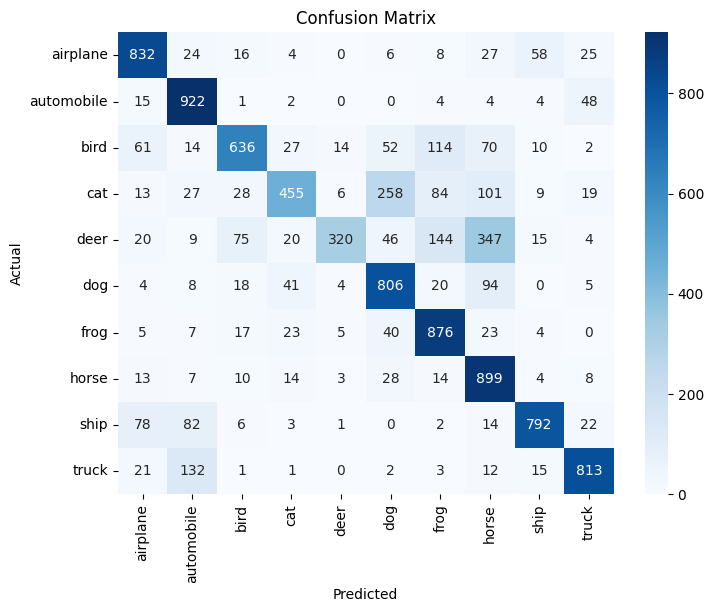

Stage 1 | Epoch 4/6 - Train Loss: 1.4252 - Val Loss: 1.1026 - Acc: 76.88%
>>> Best model saved with accuracy: 76.88%
Stage 1 | Epoch 5/6 - Train Loss: 1.4155 - Val Loss: 1.1034 - Acc: 76.53%
Stage 1 | Epoch 6/6 - Train Loss: 1.4129 - Val Loss: 1.0984 - Acc: 77.03%
>>> Best model saved with accuracy: 77.03%
>>> Checkpoint saved: checkpoint_stage1_epoch6.pth

Classification Report:
              precision    recall  f1-score   support

    airplane       0.80      0.81      0.81      1000
  automobile       0.79      0.90      0.84      1000
        bird       0.79      0.65      0.71      1000
         cat       0.72      0.59      0.65      1000
        deer       0.83      0.57      0.67      1000
         dog       0.71      0.80      0.75      1000
        frog       0.74      0.84      0.79      1000
       horse       0.68      0.86      0.76      1000
        ship       0.85      0.83      0.84      1000
       truck       0.85      0.85      0.85      1000

    accuracy         

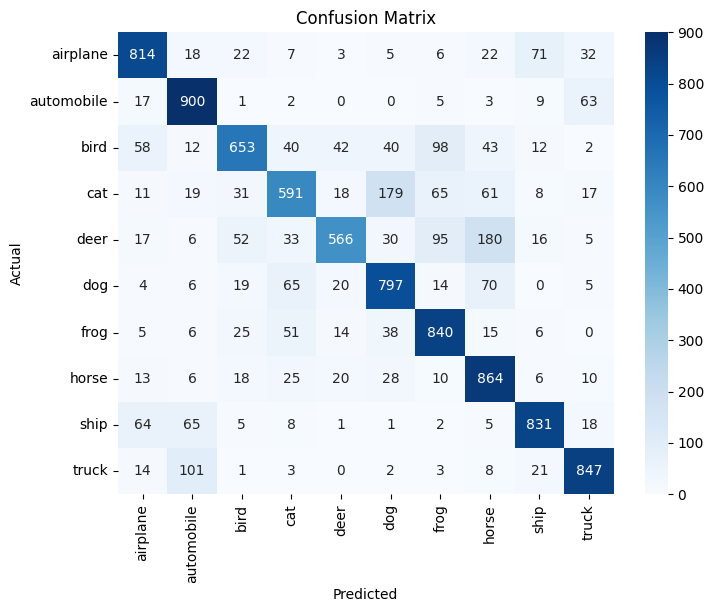


=== Stage 2 | Unfreezing: ['layer4'] | LR: 0.0005 | Epochs: 6 ===
Starting at epoch 0 for stage 2
Stage 2 | Epoch 1/6 - Train Loss: 0.9867 - Val Loss: 0.7912 - Acc: 89.51%
>>> Best model saved with accuracy: 89.51%
Stage 2 | Epoch 2/6 - Train Loss: 0.8291 - Val Loss: 0.7639 - Acc: 89.64%
>>> Best model saved with accuracy: 89.64%
Stage 2 | Epoch 3/6 - Train Loss: 0.7759 - Val Loss: 0.7138 - Acc: 91.86%
>>> Best model saved with accuracy: 91.86%
>>> Checkpoint saved: checkpoint_stage2_epoch3.pth

Classification Report:
              precision    recall  f1-score   support

    airplane       0.91      0.93      0.92      1000
  automobile       0.96      0.95      0.96      1000
        bird       0.94      0.89      0.91      1000
         cat       0.83      0.84      0.84      1000
        deer       0.92      0.92      0.92      1000
         dog       0.83      0.89      0.86      1000
        frog       0.96      0.94      0.95      1000
       horse       0.96      0.93      0.9

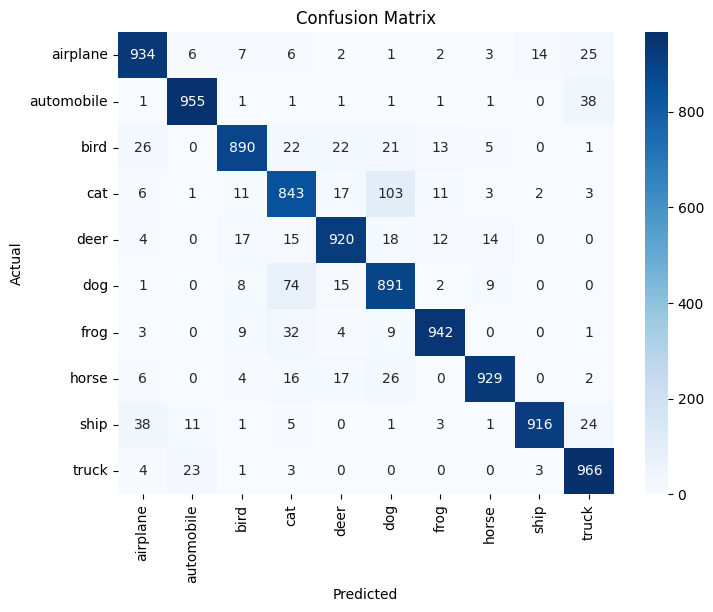

Stage 2 | Epoch 4/6 - Train Loss: 0.7296 - Val Loss: 0.6853 - Acc: 92.82%
>>> Best model saved with accuracy: 92.82%
Stage 2 | Epoch 5/6 - Train Loss: 0.6846 - Val Loss: 0.6658 - Acc: 93.44%
>>> Best model saved with accuracy: 93.44%
Stage 2 | Epoch 6/6 - Train Loss: 0.6523 - Val Loss: 0.6455 - Acc: 94.42%
>>> Best model saved with accuracy: 94.42%
>>> Checkpoint saved: checkpoint_stage2_epoch6.pth

Classification Report:
              precision    recall  f1-score   support

    airplane       0.93      0.97      0.95      1000
  automobile       0.97      0.97      0.97      1000
        bird       0.96      0.93      0.94      1000
         cat       0.89      0.87      0.88      1000
        deer       0.94      0.95      0.95      1000
         dog       0.89      0.90      0.90      1000
        frog       0.95      0.97      0.96      1000
       horse       0.97      0.95      0.96      1000
        ship       0.96      0.96      0.96      1000
       truck       0.98      0.95

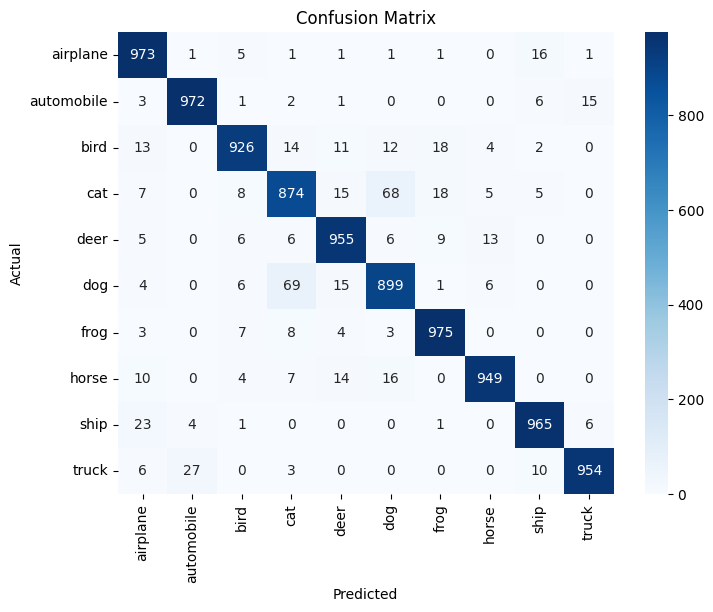


=== Stage 3 | Unfreezing: ['layer3', 'layer4'] | LR: 0.0003 | Epochs: 15 ===
Starting at epoch 0 for stage 3
Stage 3 | Epoch 1/15 - Train Loss: 0.7260 - Val Loss: 0.7155 - Acc: 91.59%
Stage 3 | Epoch 2/15 - Train Loss: 0.6948 - Val Loss: 0.6809 - Acc: 92.88%
Stage 3 | Epoch 3/15 - Train Loss: 0.6741 - Val Loss: 0.6957 - Acc: 92.55%
>>> Checkpoint saved: checkpoint_stage3_epoch3.pth

Classification Report:
              precision    recall  f1-score   support

    airplane       0.89      0.97      0.93      1000
  automobile       0.94      0.97      0.96      1000
        bird       0.92      0.92      0.92      1000
         cat       0.90      0.81      0.85      1000
        deer       0.98      0.85      0.91      1000
         dog       0.86      0.92      0.89      1000
        frog       0.94      0.97      0.96      1000
       horse       0.93      0.95      0.94      1000
        ship       0.98      0.93      0.95      1000
       truck       0.93      0.96      0.94      

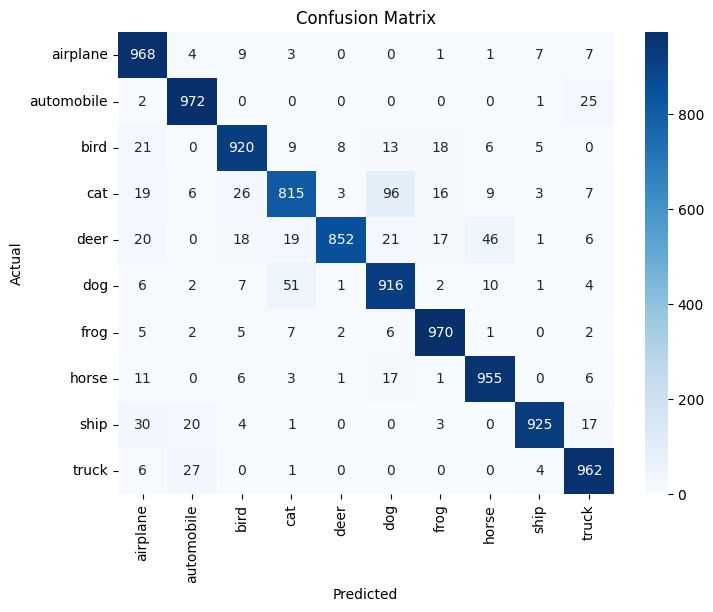

Stage 3 | Epoch 4/15 - Train Loss: 0.6581 - Val Loss: 0.6690 - Acc: 93.18%
Stage 3 | Epoch 5/15 - Train Loss: 0.6418 - Val Loss: 0.6601 - Acc: 93.72%
Stage 3 | Epoch 6/15 - Train Loss: 0.6306 - Val Loss: 0.6542 - Acc: 93.82%
>>> Checkpoint saved: checkpoint_stage3_epoch6.pth

Classification Report:
              precision    recall  f1-score   support

    airplane       0.95      0.94      0.95      1000
  automobile       0.96      0.98      0.97      1000
        bird       0.94      0.91      0.92      1000
         cat       0.84      0.90      0.87      1000
        deer       0.95      0.94      0.94      1000
         dog       0.94      0.86      0.90      1000
        frog       0.93      0.98      0.96      1000
       horse       0.96      0.96      0.96      1000
        ship       0.94      0.98      0.96      1000
       truck       0.97      0.94      0.96      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10

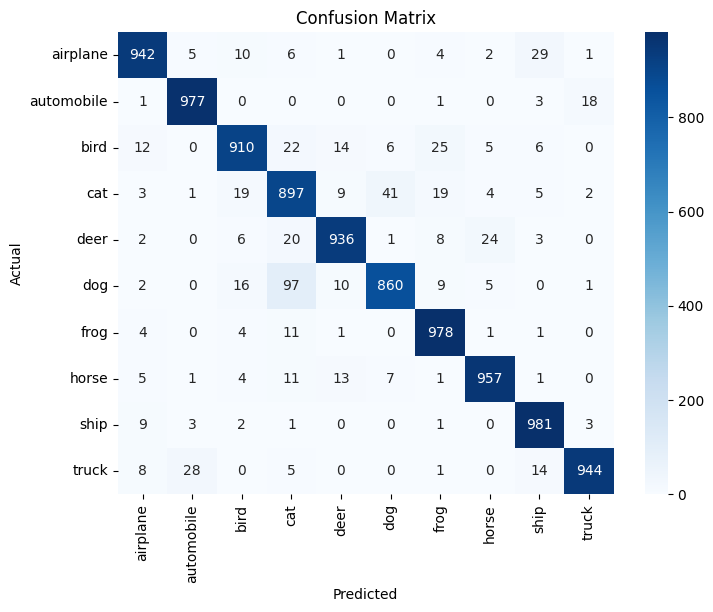

Stage 3 | Epoch 7/15 - Train Loss: 0.6159 - Val Loss: 0.6542 - Acc: 94.08%
Stage 3 | Epoch 8/15 - Train Loss: 0.6040 - Val Loss: 0.6358 - Acc: 94.78%
>>> Best model saved with accuracy: 94.78%
Stage 3 | Epoch 9/15 - Train Loss: 0.5876 - Val Loss: 0.6250 - Acc: 94.97%
>>> Best model saved with accuracy: 94.97%
>>> Checkpoint saved: checkpoint_stage3_epoch9.pth

Classification Report:
              precision    recall  f1-score   support

    airplane       0.93      0.97      0.95      1000
  automobile       0.96      0.98      0.97      1000
        bird       0.95      0.94      0.95      1000
         cat       0.90      0.88      0.89      1000
        deer       0.93      0.97      0.95      1000
         dog       0.92      0.91      0.91      1000
        frog       0.97      0.96      0.97      1000
       horse       0.97      0.97      0.97      1000
        ship       0.98      0.95      0.97      1000
       truck       0.96      0.96      0.96      1000

    accuracy      

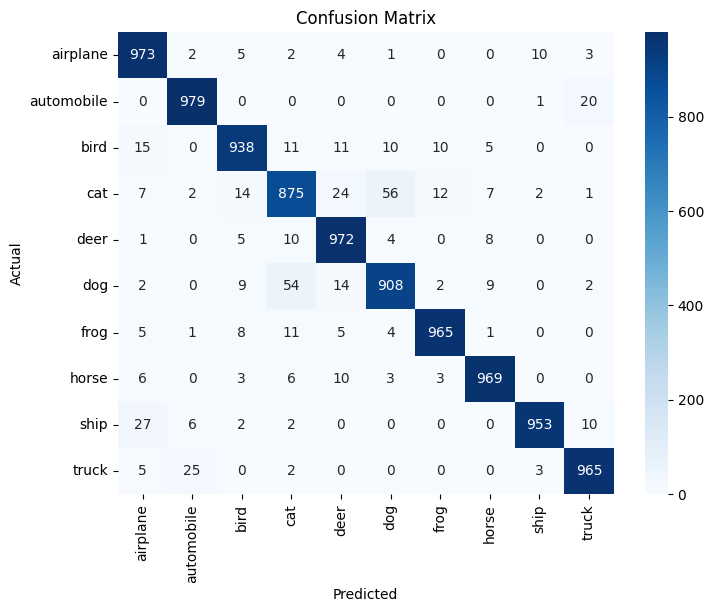

Stage 3 | Epoch 10/15 - Train Loss: 0.5750 - Val Loss: 0.6282 - Acc: 94.93%
Stage 3 | Epoch 11/15 - Train Loss: 0.5636 - Val Loss: 0.6128 - Acc: 95.50%
>>> Best model saved with accuracy: 95.50%
Stage 3 | Epoch 12/15 - Train Loss: 0.5556 - Val Loss: 0.6082 - Acc: 95.75%
>>> Best model saved with accuracy: 95.75%
>>> Checkpoint saved: checkpoint_stage3_epoch12.pth

Classification Report:
              precision    recall  f1-score   support

    airplane       0.96      0.96      0.96      1000
  automobile       0.97      0.98      0.98      1000
        bird       0.95      0.95      0.95      1000
         cat       0.88      0.92      0.90      1000
        deer       0.96      0.97      0.96      1000
         dog       0.94      0.90      0.92      1000
        frog       0.98      0.98      0.98      1000
       horse       0.98      0.97      0.97      1000
        ship       0.97      0.97      0.97      1000
       truck       0.98      0.97      0.97      1000

    accuracy  

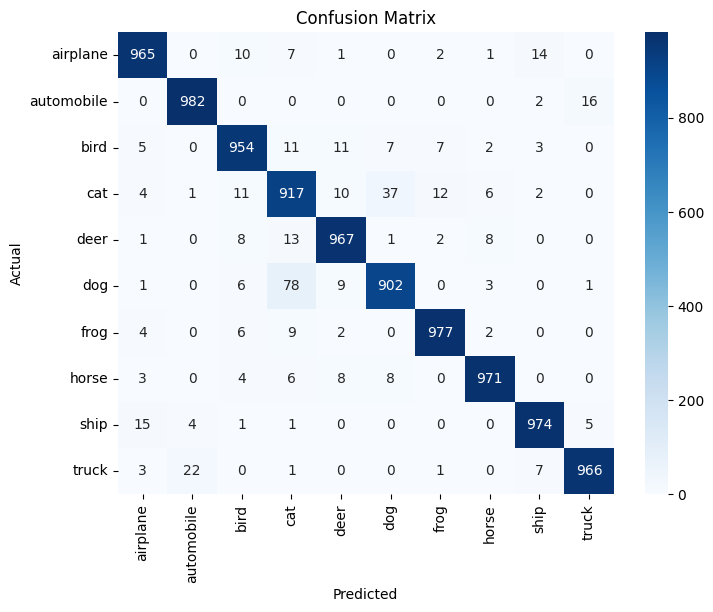

Stage 3 | Epoch 13/15 - Train Loss: 0.5507 - Val Loss: 0.6052 - Acc: 95.87%
>>> Best model saved with accuracy: 95.87%
Stage 3 | Epoch 14/15 - Train Loss: 0.5456 - Val Loss: 0.6025 - Acc: 96.06%
>>> Best model saved with accuracy: 96.06%
Stage 3 | Epoch 15/15 - Train Loss: 0.5431 - Val Loss: 0.6019 - Acc: 96.03%
>>> Checkpoint saved: checkpoint_stage3_epoch15.pth

Classification Report:
              precision    recall  f1-score   support

    airplane       0.96      0.97      0.97      1000
  automobile       0.97      0.98      0.98      1000
        bird       0.97      0.96      0.96      1000
         cat       0.91      0.91      0.91      1000
        deer       0.96      0.97      0.96      1000
         dog       0.94      0.92      0.93      1000
        frog       0.98      0.98      0.98      1000
       horse       0.97      0.97      0.97      1000
        ship       0.97      0.98      0.97      1000
       truck       0.97      0.97      0.97      1000

    accuracy  

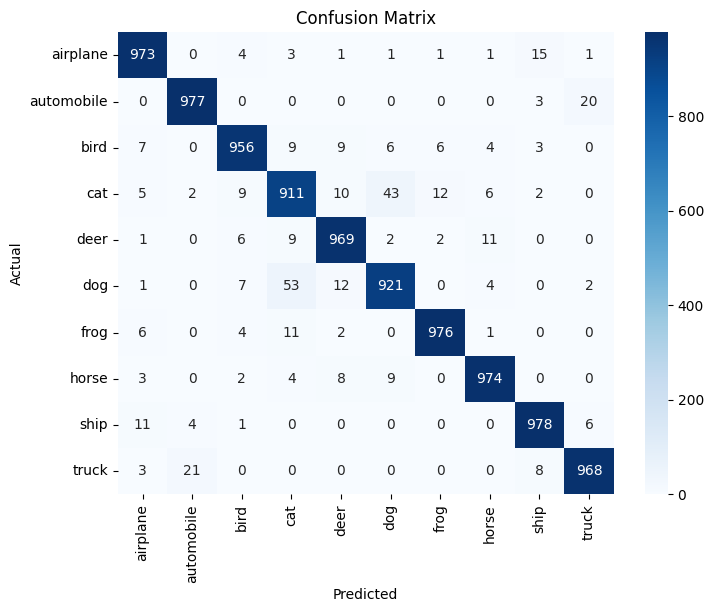

Accuracy checkpoints saved to accuracy_checkpoints.csv


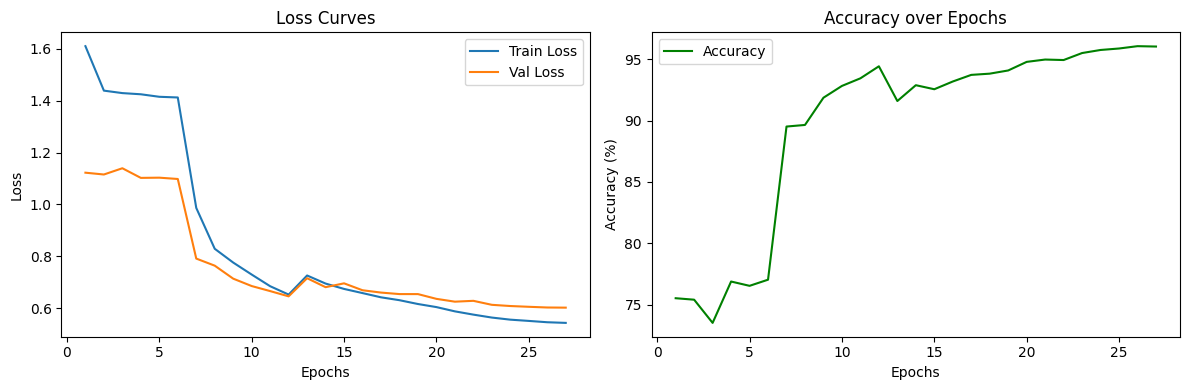

In [ ]:
if __name__ == "__main__":
    trainloader, testloader = get_dataloaders()
    model = get_model()

    stage_configs = [
        {'unfreeze': ['fc'], 'lr': 1e-3, 'epochs': 6, 'weight_decay': 5e-4},
        {'unfreeze': ['layer4'], 'lr': 5e-4, 'epochs': 6, 'weight_decay': 5e-4},
        {'unfreeze': ['layer3'], 'lr': 3e-4, 'epochs': 15, 'weight_decay': 5e-4}
    ]

    train_losses, val_losses, accuracies = train_model(model, trainloader, testloader, stage_configs)
    plot_losses(train_losses, val_losses, accuracies)


# Summary of Results

**Stage 1:** Fine-tuning Fully Connected Layers

- Layers unfrozen: fc

- Learning Rate: 0.001

- Best Accuracy: 77.03%


**Stage 2:** Unfreezing Layer4

- Layers unfrozen: layer4, fc

- Learning Rate: 0.0005

- Best Accuracy: 94.42%


**Stage 3:** Unfreezing Layer3

- Layers unfrozen: layer3, layer4, fc

- Learning Rate: 0.0003

- Best Accuracy: 96.06%



Performance overall:

- Final test Accuracy: 96.06%
- Train Loss: 0.5456
- Test Loss: 0.6025
